In [4]:
!cd /content/drive/MyDrive/파이토치실습/Pytorch_Practice

fatal: not in a git directory
fatal: not in a git directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataLoader란 Dataset을 batch기반의 딥러닝모델 학습들 위해 미니배치 형태로 만들어 실제로
# 학습할 때 이용할 수 있게 형태를 만들어준다.

# ex)
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#           batch_sampler=None, num_workers=0, collate_fn=None,
#           pin_memory=False, drop_last=False, timeout=0,
#           worker_init_fn=None)

# batch_size => 각 minibatch의 크기 즉 한번의 배치 안에 있는 샘플 사이즈를 말한다.
# shuffle => 매 Epoch마다 데이터셋을 섞어, 데이터가 학습되는 순서를 바꾸는 기능을 말한다.(True 권장.)
# num_worker => 동시에 처리하는 프로세서의 수
# collate_fn => 이 파라미터를 사용하면 별도의 데이터 처리 함수를 만들 수 있다.

In [ ]:
from torch.utils.data import Dataloader

dataloader = Dataloader(
    dataset,
    batch_size = 2,
    shuffle = True,
)

2

In [ ]:
"""
Pytorch의 dataloader를 사용하기 위해서는 필요한 input벡터들이 적절히 묶인 형태로
데이터 셋을 만들어주어야 한다.
이 과정에서는 zip함수를 사용하여도 되고, 파이토치에서 제공하는 TensorDataset함수를
사용해도 좋다.
"""

import torch
from torch.utils.data import TensorDataset

# 1. dataset 생성
X = torch.tensor([100, 200, 300])
Y = torch.tensor([1, 2, 3])

print(type(X), type(Y))

dataset_zip = list(zip(X, Y))
dataset_TD = TensorDataset(X, Y)

print(type(dataset_zip), type(dataset_TD))

# 2. DataLoader함수 설정(이제 묶은 데이터 셋을 분할해줄 준비)
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset_TD, # 위에서 생성한 데이터 셋
    batch_size = 2, #1회 당 32개의 데이터씩 분할
    shuffle = True # 데이터들의 순서는 섞어서 분할
)

# 3. 순회를 통해 분할된 데이터를 가져와 사용한다.
# DataLoader 객체는 일종의 generator형태로, 인덱싱이 불가능하다 아래처럼 batch단위의 데이터를 가져와 학습에 사용한다.

for batch in dataloader:
  batch_x = batch[0]
  batch_y = batch[1]
  print(batch_x, batch_y)
  #모델에 직접 학습할 시에는 result = model(batch_x, batch_y)와 같이 넣어준다.


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'list'> <class 'torch.utils.data.dataset.TensorDataset'>
tensor([300, 200]) tensor([3, 2])
tensor([100]) tensor([1])


In [ ]:
"""
Pytorch의 torchvision 라이브러리는 transforms에서 다양한 변환 기능을 제공한다.
transforms을 사용하여 데이터의 일부 조작을 수행하고 훈련에 적합하게 만든다.

transforms.ToTensor() - 데이터를 tensor로 바꿔준다.
transforms.Normalize(mean, std, inplace=False) - 정규화한다.
transforms.ToPILImage() - csv파일로 데이터셋을 받을 경우, PIL image로 바꿔준다.
transforms.Compose - 여러 단계로 변환해야 하는 경우, Compose를 통해 여러 단계를 묶을 수 있다.
"""

In [37]:
"""
사용자 정의 Transforms.Compose만들기
"""

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from skimage import transform

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Cuda가 잘 돌아가는지 확인한다.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [38]:
"""
디폴트 모듈 torchvision.transforms를 이용하면 구현할 수 있지만 custom하는 방법을 알아본다.
"""

transform1 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform1)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform1)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
sample = trainset[1][0].numpy()
sample.shape

(3, 32, 32)

numpy.ndarray

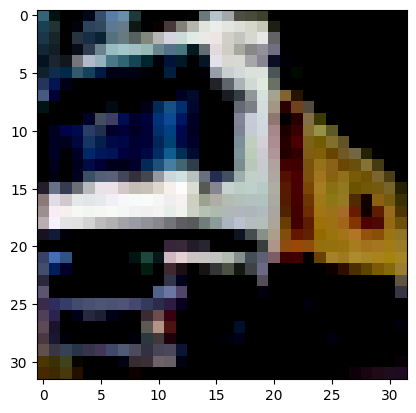

In [39]:
sample = trainset[1][0].numpy()
sample = np.transpose(sample, (1, 2, 0)) #이는 imshow가(:, :, 3)의 파일을 읽는데 우리의 데이터 셋은 (3, :, :)으로 되어있기 때문.
plt.imshow(sample)
type(sample)

In [47]:
class Rescale(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    self.output_size = output_size

  def __call__(self, sample):
    image=sample

    h, w = image.shape[:2]

    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h/w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w/h

    else:
      new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image, (new_h, new_w))
    return img

class RandomCrop(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)

    else:
      assert len(output_size) == 2
      self.output_size = output_size

  def __call__(self, sample):
    image=sample

    h, w = image.shape[:2]

    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top + new_h, left: left + new_w]

    return image





In [48]:
scale = Rescale(24)
crop = RandomCrop(18)
composed = transforms.Compose([Rescale(24), RandomCrop(18)])


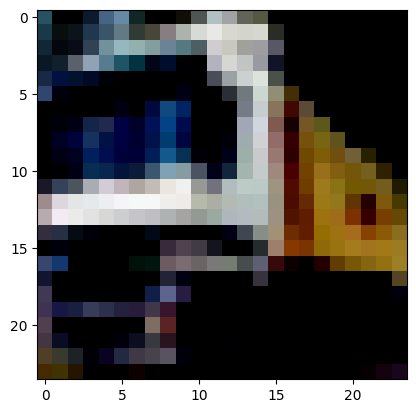

In [50]:
plt.imshow(scale(sample))